# First assessment of the algorithm

```{note}
This document is a runnable notebook. See its corresponding github website for a static view with all code displayed.
```

In [1]:
using Revise
includet("common_functions.jl")
using Dates
using HDF5
nsidcg=OEM.nsidcg()
mycrs=nsidcg.to_cartopy_crs();
llur=getindex.(Ref(nsidcg.area_extent),[0,2,1,3])
plt=pyplot 
cfeature=pyimport("cartopy.feature")
using StaticArrays 
using Accessors
labs=["wind speed [m/s]","total water vapor [kg/m²]","cloud liquid water [kg/m²]",
    "sea surface temperature [K]","ice surface temperature [K]","sea ice concentration [1]",
    "multi year ice fraction [1]","first year ice thickness [cm]","sea surface salinity [ppt]"]

  Activating project at `/mnt/pharoshome/huntemann/Projects/DEVALGO/MultiParameter_ATBD_V2/algorithm/algoenv`


9-element Vector{String}:
 "wind speed [m/s]"
 "total water vapor [kg/m²]"
 "cloud liquid water [kg/m²]"
 "sea surface temperature [K]"
 "ice surface temperature [K]"
 "sea ice concentration [1]"
 "multi year ice fraction [1]"
 "first year ice thickness [cm]"
 "sea surface salinity [ppt]"

In [2]:
D=Date(2021,11,10)
if filesize("../data/oem_input.h5")>0
    outg = h5read("../data/oem_input.h5","/TBS_14") |> x->[x[:,:,i] for i in 1:size(x,3)]
    wsp,twv,clw,t2m,tsk=h5read("../data/oem_input.h5","/era5") |> x->[x[:,:,i] for i in 1:size(x,3)]
else
    wsp,twv,clw,t2m,tsk=get_ecmwf_on_NSIDC(D) 
    outg=prepare_oem_tbs(D);
    h5write("../data/oem_input.h5","/TBS_14",cat(outg...,dims=3))
    h5write("../data/oem_input.h5","/era5",cat(wsp,twv,clw,t2m,tsk,dims=3))
end

5-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

In [3]:
function plot_oem_out(dat,D,save=false)
    dat=deepcopy(dat)
    fig,ax=plt.subplots(nrows=3,ncols=3,figsize=[15,15], subplot_kw=PyDict(Dict("projection"=> mycrs)))
    ax=pyconvert(Array,ax)

    mins=[0,0,0,240,240,0,0,0,25]
    maxs=[20,20,.5,280,280,1,1,150,40]
    labs=["wind speed [m/s]","total water vapor [kg/m²]","cloud liquid water [kg/m²]",
    "sea surface temperature [K]","ice surface temperature [K]","sea ice concentration [1]",
    "multi year ice fraction [1]","first year ice thickness [cm]","sea surface salinity [ppt]"]
    sic=dat[:,6]

    dat[sic.>0.9,1].=NaN
    dat[sic.>0.9,4].=NaN
    dat[sic.<0.1,5].=NaN
    dat[sic.<0.1,7].=NaN
    dat[sic.<0.1,8].=NaN
    dat[sic.>0.9,9].=NaN

    extent=[-3,3,-3,3].*1e6

    #cm=plt.cm.gist_ncar
    cm=plt.cm.viridis
    cm.set_bad("grey")
    cm.set_under("grey")

    size(dat[1])
    for i=1:9
        pos=ax[i].imshow(reshape(dat[:,i], 896, 608),extent=llur,vmin=mins[i],vmax=maxs[i],cmap=cm,transform=mycrs)
        cb=fig.colorbar(pos,ax=ax[i],shrink=0.7,orientation="vertical",pad=0.01)
        ax[i].set_title(labs[i])
        ax[i].set_extent(extent,mycrs)
        ax[i].coastlines()
        land_50m = cfeature.NaturalEarthFeature("physical", "land", "50m", edgecolor="face", facecolor=cfeature.COLORS["land"])
        ax[i].add_feature(land_50m)

    end
    #ax[10].set_visible(false)
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    if save
        plt.savefig("outmaps/oem_sit_$(Dates.format(D,"yyyymmdd")).png",dpi=200,bbox_inches="tight")
    end
    return fig
end

function plot_oem_err(dat,D,save=false)
    dat=deepcopy(dat)
    fig,ax=plt.subplots(nrows=3,ncols=3,figsize=[15,15],subplot_kw=PyDict(Dict("projection"=> mycrs)))
    ax=pyconvert(Array,ax)

    mins=[0,0,0,0,0,0,0,0,0]
    maxs=[10,10,0.5,3,3,0.3,0.3,100,5]
    labs=["wind speed [m/s]","total water vapor [kg/m²]","cloud liquid water [kg/m²]","sea surface temperature [K]","ice surface temperature [K]","sea ice concentration [1]","multi year ice fraction [1]","first year ice thickness [cm]","sea surface salinity [ppt]"]
    #sic=dat[6]

    #dat[1][sic.>0.9].=NaN
    #dat[4][sic.>0.9].=NaN
    #dat[5][sic.<0.1].=NaN
    #dat[7][sic.<0.1].=NaN
    #dat[8][sic.<0.1].=NaN

    extent=[-3,3,-3,3].*1e6

    cm=plt.cm.CMRmap
    cm.set_bad("grey")

    size(dat[1])
    for i=1:9
        pos=ax[i].imshow(reshape(dat[:,i], 896, 608),extent=llur,vmin=mins[i],vmax=maxs[i],cmap=cm)
        cb=fig.colorbar(pos,ax=ax[i],shrink=0.7,orientation="vertical",pad=0.01)
        ax[i].set_title(labs[i])
        ax[i].set_extent(extent,mycrs)
        ax[i].coastlines()

    end
    #ax[10].set_visible(false)
    plt.subplots_adjust(wspace=0.01,hspace=0.01)

    if save
        plt.savefig("outmaps/oem_sit_$(Dates.format(D,"yyyymmdd")).png",dpi=200,bbox_inches="tight")
    end
    return fig
end

function plot_oem_res(res,D,save=false,cimr_only=true)
    cols=cimr_only ? 5 : 7
    fig,ax=plt.subplots(nrows=2,ncols=cols,figsize=[20,10],subplot_kw=PyDict(Dict("projection"=> mycrs)))
    ax=pyconvert(Array,ax)
    mins=fill(-10,14)
    maxs=fill(10,14)
    if cimr_only
        freqs=[1.4,6.93, 10.65, 18.70, 36.50]
    else
        freqs=[1.4,6.93, 10.65, 18.70, 23.80, 36.50, 89.0]
    end
    
    labs=["$(freqs[(i+1)÷2])$(["h","v"][(i)%2+1])" for i=1:(cols*2)]
    sic=dat[6]

    extent=[-3,3,-3,3].*1e6
    cm=plt.cm.bwr
    cm.set_bad("grey")
    for i=1:(cols*2)
        pos=ax[i].imshow(reshape(res[:,i], 896, 608),extent=llur,vmin=mins[i],vmax=maxs[i],cmap=cm)
        cb=fig.colorbar(pos,ax=ax[i],shrink=0.8,orientation="horizontal",pad=0.01)
        ax[i].set_title(labs[i])
        ax[i].set_extent(extent,mycrs)
        ax[i].coastlines()

    end

    plt.subplots_adjust(wspace=0.01,hspace=0.01)

    if save
        plt.savefig("outmaps/oem_sit_res_$(Dates.format(D,"yyyymmdd")).png",dpi=200,bbox_inches="tight")
        return nothing
    end
    return fig
end

plot_oem_res (generic function with 3 methods)

In [4]:
noutg=cat((outg[i][:] for i=[1:8; 11:12])...,dims=2)

ind=findfirst(all(noutg[:,i].>0) for i=1:10)

noutg[1300,:]

10-element Vector{Float32}:
 NaN
 NaN
 161.11
  79.17
 167.63
  85.79
 187.96
 105.44
 215.37
 149.73

In [5]:
#wsp[:]
#@time dat,errr,res=run_oem(outg,wsp,twv,clw,t2m,tsk,DataType);
band_data= noutg 
apriori=cat(wsp[:],twv[:],clw[:],t2m[:],tsk[:],
0.5*ones(length(wsp)) , #ic #good guess when initial value from TBs
0.5*ones(length(wsp)), #myi # good guess when initial value from TBs
100.0*ones(length(wsp)), #sit
30.0*ones(length(wsp)) # sss
,dims=2)

dat,errr,res=run_oem(noutg,apriori=apriori)


([NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0  …  51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0])

## Application to SMOS and AMSR2 data
We apply the algorithm to the daily averaged {term}`SMOS` and {term}`AMSR2` data
for the 10 November 2021. For AMSR2 we exclude the 23 and 89 GHz channels from
the calculation as it is not available on the {term}`CIMR` satellite.
The retrieval is constrained using a priori information from {term}`ERA5` from the 10 November 2021, in
particular for the atmospheric parameters and temperatures. The {numref}`fig:retrievalexample` shows the results of the retrieval with maps of all eight parameters. The data data displayed is limited by the SMOS observation at 53° incidence angle towards the pole, which creates a rather large pole hole. Some parameters like the {term}`SIC` are strongly constrained from the input brightness temperatures and thus look very consistent. The {term}`MYI` shows reasonable results north of Greenland and the Canadian Archipelago. Some artifacts can be seen in {term}`MYI` along the ice edge. The {term}`SIT` shows low values in the marginal ice zones between 40&nbsp;cm and 80&nbsp;cm which is not unrealistic in the early freeze-up season. Here, only the ice thickness of the fraction of first year ice is shown, so that at higher {term}`MYI`, The retrieved {term}`SIT` is less reliable. 
The {term}`SST` and {term}`IST` show little variability and are close to their apri ori values (ERA5).
The atmospheric parameters {term}`CLW` and {term}`TWV`, and the wind speed are fast changing parameters. Therefore, the daily averaged brightness temperature input may alter the results and let swath edges shine through the results. For {term}`CLW` and {term}`TWV`, some values are outside of the retrieval range and are displayed in gray, just like NaN values. This is mainly the case over sea ice, where the retrieval is not so sensitive to atmospheric parameters, in particular at CIMR frequencies.





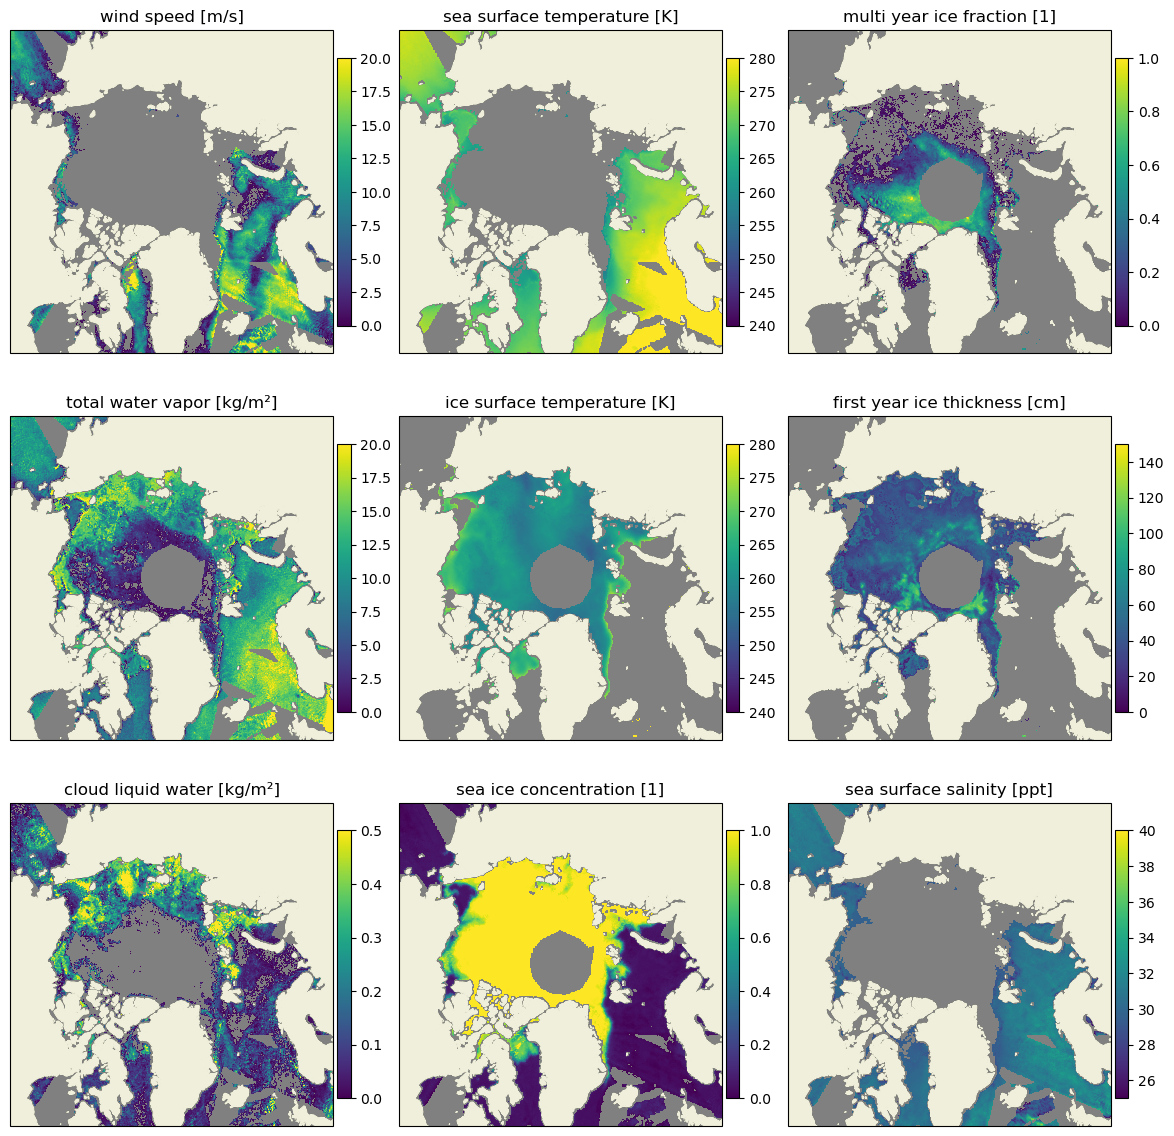

~~~markdown
```{figure} figures/figure_fig:retrievalexample.png
:name: fig:retrievalexample

Maps of retrieval results from the multi parameter retrieval for 10 November 2021 using AMSR2 and SMOS data for all CIMR frequencies.
```

~~~

In [6]:
fig=plot_oem_out(dat,D,false)
#display(fig)
plot_with_caption(fig,"Maps of retrieval results from the multi parameter retrieval for 10 November 2021 using AMSR2 and SMOS data for all CIMR frequencies.","fig:retrievalexample")


Looking at the uncertainties of the retrieved quantities in {numref}`fig:retrievalexampleuncertainty`, it seems that the retrieval improved the knowledge in many cases. The apri ori uncertainty is always corresponding to the highest values in each subplot. For example, the a priori uncertainty of wind speed was set to 10&nbsp;m/s. Since wind speed cannot be retrieved over 100% sea ice, the entire ice area has a wind speed uncertainty of 10&nbsp;m/s. Over ocean however this value goes down to nearly 4&nbsp;m/s uncertainty. This means our knowledge about the wind speed in these areas increased drastically by this measurement. Our knowledge about the SSS barely increased with the measurement, which is consistent with our expectation that SSS has little influence on the brightness temperatures compared to other variables.

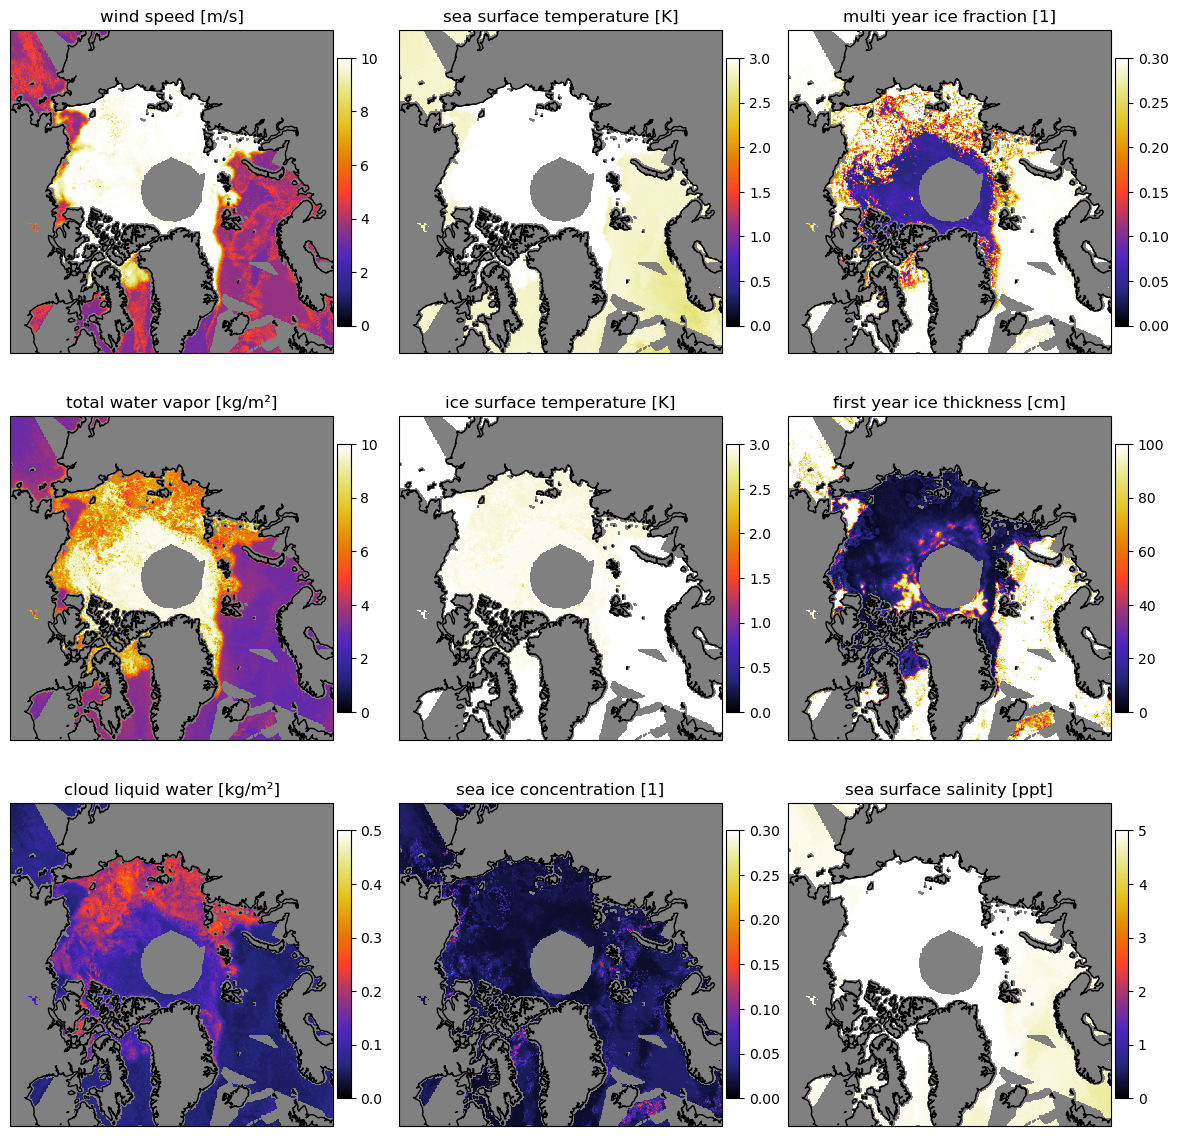

~~~markdown
```{figure} figures/figure_fig:retrievalexampleuncertainty.png
:name: fig:retrievalexampleuncertainty

Maps of retrieval uncertainties for 10 November 2021 for the multi parameter retrieval using AMSR2 and SMOS data, using all CIMR frequencies.
```

~~~

In [7]:
fig=plot_oem_err(errr,D,false)
plot_with_caption(fig,"Maps of retrieval uncertainties for 10 November 2021 for the multi parameter retrieval using AMSR2 and SMOS data, using all CIMR frequencies.","fig:retrievalexampleuncertainty")

Another output of the retrieval are the brightness temperatures of the best estimate of the parameters. With this information, the result vector of brightness temperatures can be compared to the input vector, i.e., the observed brightness temperatures from the instrument. With a good working forward model, it is expected that the differences of the brightness temperatures in each channel are small. In {numref}`fig:retrievalexampleresiduals`, at vertical polarization (upper row) the forward model solution looks very similar to the measurement from the instrument, except for L-band. At horizontal polarization (lower row), strong discrepancies, especially over Sea ice can be seen. Comparing the pattern to the geophysical quantities from the first Figure, it is evident that the first year ice areas cause a major problem in the forward model. 
```{note}
The accuracy of the brightness temperatures and forward model uncertainties determine the weight of the brightness temperatures at each channel. These parameters are not yet evaluated in this assessment and must be investigated before the retrieval can be implemented in an operational system.
```

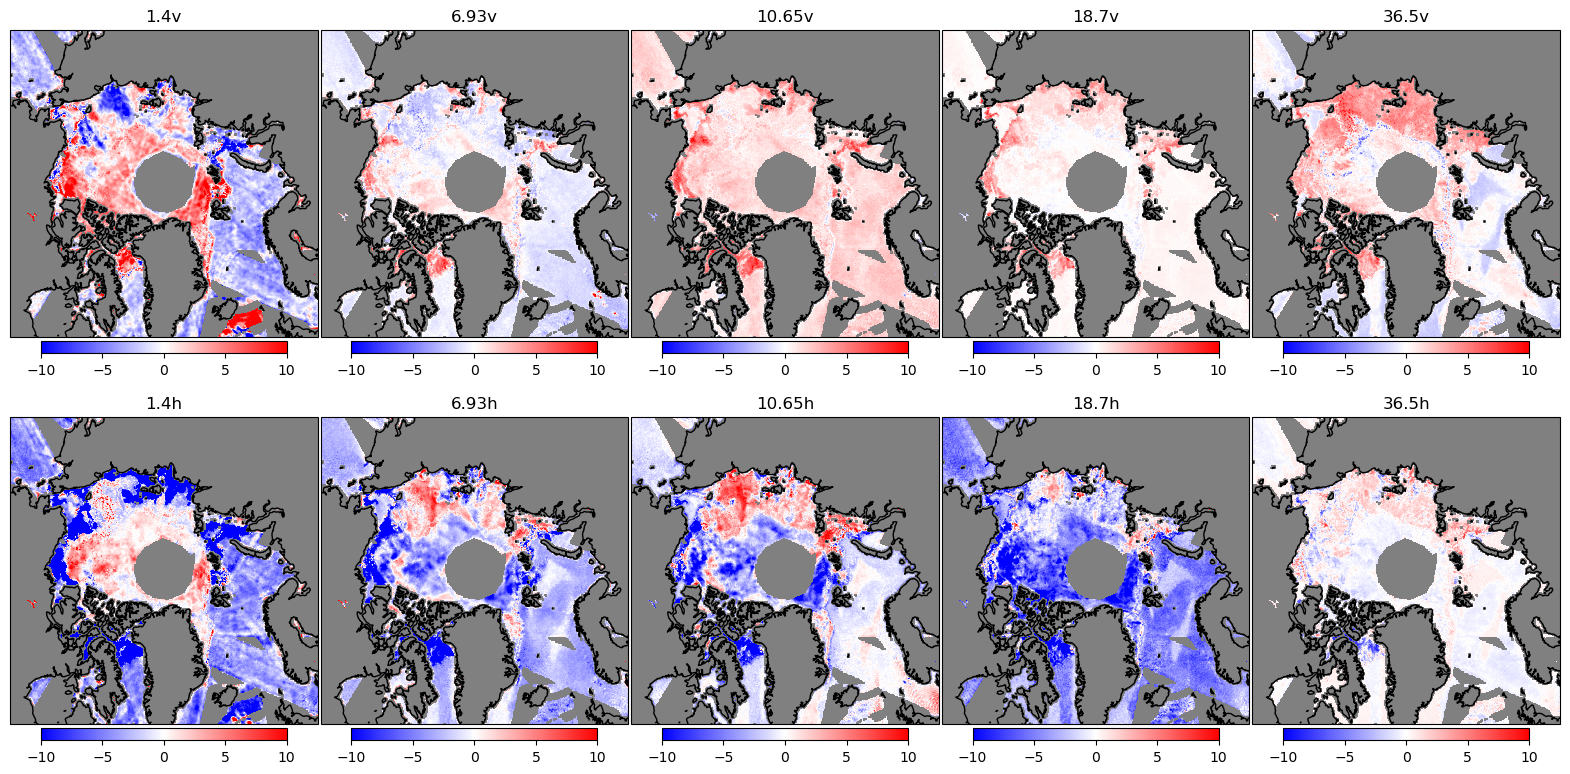

~~~markdown
```{figure} figures/figure_fig:retrievalexampleresiduals.png
:name: fig:retrievalexampleresiduals

Maps of the differences between retrieved brightness temperatures and input measurements.
```

~~~

In [8]:
fig=plot_oem_res(res,D,false,true)
plot_with_caption(fig,"Maps of the differences between retrieved brightness temperatures and input measurements.","fig:retrievalexampleresiduals")

In [9]:
ch=["$i$p" for i in [1.4,6.9, 10.7, 18.7, 23.80, 36.50, 89.0] for p in ["v","h"]]

14-element Vector{String}:
 "1.4v"
 "1.4h"
 "6.9v"
 "6.9h"
 "10.7v"
 "10.7h"
 "18.7v"
 "18.7h"
 "23.8v"
 "23.8h"
 "36.5v"
 "36.5h"
 "89.0v"
 "89.0h"

## Forward model illustration (examples)

A small illustration of the forward model is shown in the next few figures. Parameters which are not varried in the following are kept at a fixed value which is shown in table {numref}`fixed_parameters`.



In [19]:
fw_input= SA[2.0,0.2,0.1,278,260,1.0,1.0,80,35]

if get(ENV,"JUPYTER_BOOK_BUILD", "false") == "true"
  out_string="""```{list-table} Fixed parameters for the forward model illustration
  :name: fixed_parameters
  :header-rows: 1

  * - Parameter
    - Value
  """
  for i=1:9
      out_string*="""* - $(labs[i])
    - $(fw_input[i])
  """
  end
  out_string*="\n```"
else
  out_string="~~~markdown\n:name: fixed_parameters\n:header-rows: 1\n~~~\n"
  out_string*="| Parameter | Value |\n| --- | --- |\n"
  for i=1:9
      out_string*="| $(labs[i]) | $(fw_input[i]) |\n"
  end
end
out_string |>x->display("text/markdown",x)
nothing

```{list-table} Fixed parameters for the forward model illustration
:name: fixed_parameters
:header-rows: 1

* - Parameter
  - Value
* - wind speed [m/s]
  - 2.0
* - total water vapor [kg/m²]
  - 0.2
* - cloud liquid water [kg/m²]
  - 0.1
* - sea surface temperature [K]
  - 278.0
* - ice surface temperature [K]
  - 260.0
* - sea ice concentration [1]
  - 1.0
* - multi year ice fraction [1]
  - 1.0
* - first year ice thickness [cm]
  - 80.0
* - sea surface salinity [ppt]
  - 35.0

```


### Wind Speed
The brightness temperature as a function of wind speed over open ocean (SIC = 0, otherwise values from {numref}`fixed_parameters`) area is shown in {numref}`wind_speed_illustration` for all CIMR channels. The brightness temperature is increasing with increasing wind speed. The effect is strongest at higher frequencies while it is barely visible at L-band according to this forward simulation. Also, at vertical polarization, the effect is smaller than at horizontal polarization.

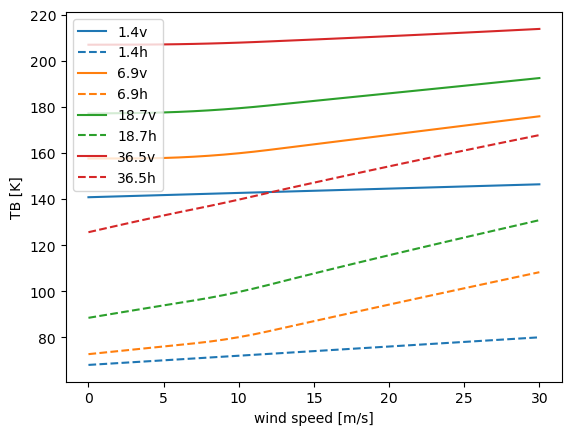

~~~markdown
```{figure} figures/figure_wind_speed_illustration.png
:name: wind_speed_illustration

Brightness temperature and wind speed for different frequencies as calculated from the forward model.
```

~~~

In [11]:
fig=plt.figure()
#cs=[1,2,5,6,11,12]
cs=[1,2,3,4,7,8,11,12]
ls = ["-","--"]
fw_ow_input=@set fw_input[6]=1e-5

for c in 1:length(cs)
plt.plot([getindex(fw_fnct_amsre(@set fw_ow_input[1]=i),cs[c]) for i=0:1:30],label=ch[cs[c]],color="C$((c-1)÷2)", linestyle=ls[(c-1)%2+1])
end
plt.legend()
#plt.ylim(200,300)
plt.ylabel("TB [K]")
plt.xlabel("wind speed [m/s]")
plot_with_caption(fig, "Brightness temperature and wind speed for different frequencies as calculated from the forward model.", "wind_speed_illustration");

### Ice Surface Temperature
Similarly to the wind speed dependence, we illustrate the ice surface temperature in {numref}`ice_temperature_illustration` keeping otherwise the parameters listed in {numref}`fixed_parameters`. Increasing ice surface temperature cause an increase in all brightness temperatures at both polarizations, but the effect is stronger with higher frequencies. The temperature effect on the polarization is not that pronounced as seen in wind speed before.

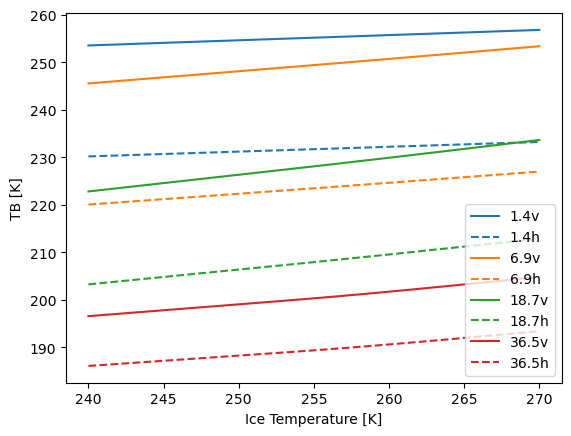

~~~markdown
```{figure} figures/figure_ice_temperature_illustration.png
:name: ice_temperature_illustration

Brightness temperature against ice temperature for different frequencies as calculated from the forward model.
```

~~~

In [12]:
fig=plt.figure()
cs=[1,2,3,4,7,8,11,12]
prange=240:270
for c in 1:length(cs)
plt.plot(prange,[getindex(fw_fnct_amsre((@set fw_input[5]=i)),cs[c]) for i=prange],label=ch[cs[c]],color="C$((c-1)÷2)", linestyle=ls[(c-1)%2+1])
end
plt.legend()
#plt.ylim(200,300)
plt.ylabel("TB [K]")
plt.xlabel("Ice Temperature [K]")
plot_with_caption(fig, "Brightness temperature against ice temperature for different frequencies as calculated from the forward model.", "ice_temperature_illustration")

### Multi-year ice fraction
The dependence of the brightness temperature on the multi-year ice concentration is shown in {numref}`multiyear_ice_fraction_illustration`. While at L-band, both polarizations show a slight increase with increasing multi-year ice fraction, the other channels show a decrease. The decrease is increasing with increasing frequency. 


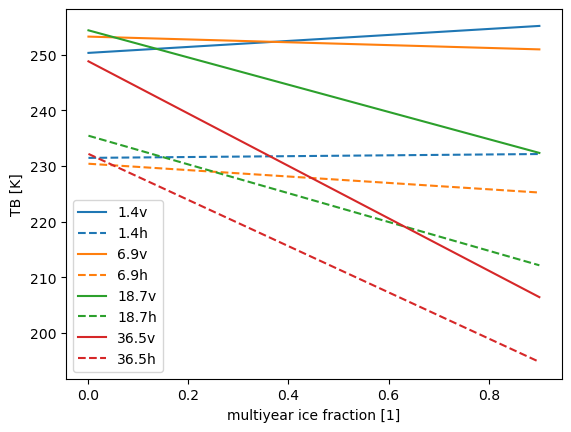

~~~markdown
```{figure} figures/figure_multiyear_ice_fraction_illustration.png
:name: multiyear_ice_fraction_illustration

Brightness temperature against multiyear ice fraction for different frequencies as calculated from the forward model.
```

~~~

In [13]:
fig=plt.figure()
cs=[1,2,3,4,7,8,11,12]
prange=0.001:0.1:1.0
for c in 1:length(cs)
plt.plot(prange,[getindex(fw_fnct_amsre(@set fw_input[7]=i),cs[c]) for i=prange],label=ch[cs[c]],color="C$((c-1)÷2)", linestyle=ls[(c-1)%2+1])
end
plt.legend()
#plt.ylim(200,300)
plt.ylabel("TB [K]")
plt.xlabel("multiyear ice fraction [1]")
plot_with_caption(fig, "Brightness temperature against multiyear ice fraction for different frequencies as calculated from the forward model.", "multiyear_ice_fraction_illustration")

### Ice thickness (first year ice)
For the ice thickness, the effect on the brightness temperature is shown in {numref}`ice_thickness_illustration`. The effect is strongest at L-band and decreases with increasing frequency. The effect is stronger at horizontal polarization than at vertical polarization. The strong increase of brightness temperature at thin ice thickness across frequencies is due to the strong increase in emission in the initial ice growth phase. The saturation of brightness temperatures at increasing ice thickness is due to the fact that the ice is not transparent anymore for the microwave at the given frequency. The lower the frequency, the higher the penetration depth of the microwave signal. 
```{note}
In passive microwave remote sensing the term *penetration depth* is still used, even though technically, the microwave signal is not penetrating into the surface but originating from it. The term is used to describe the depth at which the majority of the microwave signal is originating from. 
```

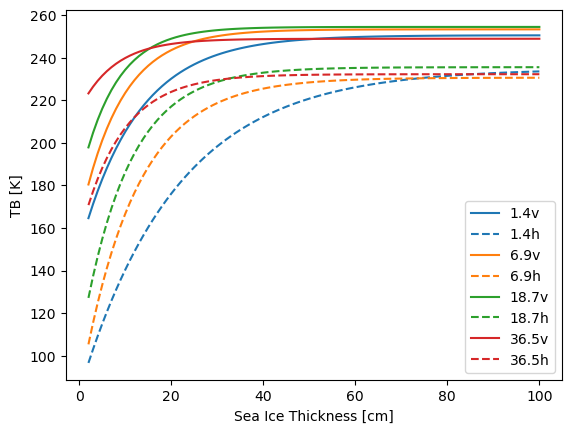

~~~markdown
```{figure} figures/figure_sea_ice_thickness_illustration.png
:name: sea_ice_thickness_illustration

Brightness temperature against sea ice thickness for different frequencies as calculated from the forward model.
```

~~~

In [14]:
fig=plt.figure()
cs=[1,2,3,4,7,8,11,12]
prange=2:1:100.0
for c in 1:length(cs)
plt.plot(prange,[getindex(fw_fnct_amsre(SA[2,0.2,0.1,278,260,1.0,0.0,i,35]),cs[c]) for i=prange],label=ch[cs[c]],color="C$((c-1)÷2)", linestyle=ls[(c-1)%2+1])
end
plt.legend()
#plt.ylim(200,300)
plt.ylabel("TB [K]")
plt.xlabel("Sea Ice Thickness [cm]")
plot_with_caption(fig, "Brightness temperature against sea ice thickness for different frequencies as calculated from the forward model.", "ice_thickness_illustration")

In [15]:
using BenchmarkTools
@btime fw_fnct_amsre(SA[10,0.2,0.1,273,270,0.000001,1.0,0.1,39])

  1.458 μs (0 allocations: 0 bytes)


14-element SVector{14, Float64} with indices SOneTo(14):
 140.06561493459574
  70.73503770667914
 157.7898500250851
  79.39123546346629
 164.14244230902978
  84.75091149141443
 179.6631477444441
 100.69139043211493
 188.7186939913016
 111.52033110120007
 208.37261378616228
 141.47905772512567
 238.54809759345068
 189.05982922268922